In [89]:
import itertools

import numpy.random as random
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, ParameterGrid
from keras.models import Sequential
from keras.layers import Dense
from keras import activations, optimizers, regularizers, losses, initializers


# 4 - Assignment Part 2

In [90]:
def mackey_glass(t, mg_dict, beta=0.2, gamma=0.1, n=10, r=25):
    if t == 0:
        return 1.5
    elif t < 0:
        return 0

    if mg_dict.get(t):
        return mg_dict.get(t)

    t_prev = t - 1

    if not mg_dict.get(t_prev):
        mg_dict[t_prev] = mackey_glass(t_prev, mg_dict)

    mg_t = mg_dict.get(t_prev)

    if not mg_dict.get(t_prev - r):
        mg_dict[t_prev - r] = mackey_glass(t_prev - r, mg_dict)

    mg_tr = mg_dict.get(t_prev - r)

    return mg_t + (beta * mg_tr) / (1 + mg_tr ** n) - gamma * mg_t


mg_dict = {}
input = []
output = []
for t in range(300, 1500):
    input.append([mackey_glass(t - 20, mg_dict), mackey_glass(t - 15, mg_dict), mackey_glass(t - 10, mg_dict),
                  mackey_glass(t - 5, mg_dict), mackey_glass(t, mg_dict)])
    output.append(mackey_glass(t + 5, mg_dict))

input = np.array(input)
output = np.array(output)


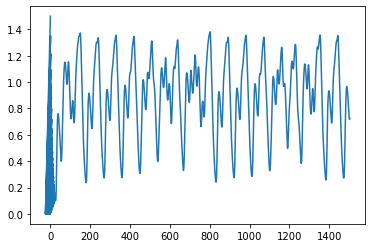

In [101]:
plt.plot(mg_dict.keys(), mg_dict.values())
plt.show()

In [92]:
# consecutive blocks of the time series: train -> val -> test
X_train_val, X_test, y_train_val, y_test = train_test_split(input, output, test_size=200, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=False)


In [99]:
def create_model(hidden_layer_nodes=[5, 6], input_shape=5, output_shape=1, learning_rate=0.1, momentum=0.5,
                 activation=activations.sigmoid, final_activation=activations.linear,
                 kernel_initializer=initializers.GlorotNormal(),
                 bias_initializer=initializers.Zeros(),
                 regularizer=regularizers.L1(0.0001)):
    model = Sequential()
    for i, nodes in enumerate(hidden_layer_nodes):
        if i == 0:
            print("New input layer:", "input_shape", input_shape, "nodes", nodes)
            model.add(Dense(nodes,
                            input_dim=input_shape,
                            activation=activation,
                            kernel_initializer=kernel_initializer,
                            bias_initializer=bias_initializer,
                            #choose L1 because the weights are not equally important
                            kernel_regularizer=regularizer,
                            bias_regularizer=regularizer))
        else:
            print("New hidden layer:", "nodes", nodes)
            model.add(Dense(nodes,
                            activation=activation,
                            kernel_initializer=kernel_initializer,
                            bias_initializer=bias_initializer,
                            kernel_regularizer=regularizer,
                            bias_regularizer=regularizer))

    print("New output layer:", "output_shape", output_shape)
    model.add(Dense(output_shape,
                    activation=final_activation,
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,
                    kernel_regularizer=regularizer,
                    bias_regularizer=regularizer))

    optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(loss=losses.mean_squared_error, optimizer=optimizer, metrics=['mse'])
    return model


In [107]:
#lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2, decay_steps=10000, decay_rate=0.9)
model = create_model()
es = EarlyStopping(monitor='val_mse', mode='min', patience=10, min_delta=0.0001, verbose=1, restore_best_weights=0)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=10, callbacks=es)


New input layer: input_shape 5 nodes 9
New hidden layer: nodes 9
New output layer: output_shape 1
Epoch 1/500
80/80 [==============================] - 1s 3ms/step - loss: 0.1639 - mse: 0.1224 - val_loss: 0.0976 - val_mse: 0.0561
Epoch 2/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1307 - mse: 0.0892 - val_loss: 0.0966 - val_mse: 0.0552
Epoch 3/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1302 - mse: 0.0888 - val_loss: 0.0964 - val_mse: 0.0551
Epoch 4/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1296 - mse: 0.0883 - val_loss: 0.0964 - val_mse: 0.0552
Epoch 5/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1292 - mse: 0.0880 - val_loss: 0.0968 - val_mse: 0.0558
Epoch 6/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1284 - mse: 0.0874 - val_loss: 0.0949 - val_mse: 0.0540
Epoch 7/500
80/80 [==============================] - 0s 1ms/step - loss: 0.1279 - mse: 0.0871 - val_loss: 0.0947 - v

In [100]:
def grid_search(param_dict, _X_train, _y_train, _X_val, _y_val):
    param_grids = list(ParameterGrid(param_dict))
    print(len(param_grids))

    es = EarlyStopping(monitor='val_mse', mode='min', patience=20, min_delta=0.0001, verbose=1, restore_best_weights=0)
    models = []
    histories = []

    for params in param_grids:
        print(params)
        model = create_model(**params)
        history = model.fit(_X_train, _y_train, validation_data=(_X_val, _y_val), epochs=500, batch_size=10, callbacks=es)
        models.append(model)
        histories.append(history.history)

    final_val_mses = np.around([history['val_mse'][-1] for history in histories], 4)
    final_train_mses = np.around([history['mse'][-1] for history in histories], 4)
    used_epochs = [len(history['val_mse']) for history in histories]
    eval_grid = zip(param_grids, models, histories, final_train_mses, final_val_mses, used_epochs)
    eval_grid = sorted(eval_grid, key=lambda x: x[4])

    for i, (param, model, history, final_train_mse, final_val_mse, epoch) in enumerate(eval_grid):
        print(i, final_train_mse, final_val_mse, epoch, param)

    return eval_grid

# Find best hidden layers

In [78]:
nh1 = [3, 4, 5]
nh2 = [2, 4, 6]
layers = [list(items) for items in itertools.product(nh1, nh2)]

param_dict = dict(hidden_layer_nodes=layers)

arch_eval_grid = grid_search(param_dict, X_train, y_train, X_val, y_val)


9
{'hidden_layer_nodes': [3, 2]}
New input layer: input_shape 5 nodes 3
New hidden layer: nodes 2
New output layer: output_shape 1
Epoch 1/500
80/80 [==============================] - 1s 4ms/step - loss: 0.0980 - mse: 0.0930 - val_loss: 0.0580 - val_mse: 0.0530
Epoch 2/500
80/80 [==============================] - 0s 2ms/step - loss: 0.0947 - mse: 0.0896 - val_loss: 0.0644 - val_mse: 0.0594
Epoch 3/500
80/80 [==============================] - 0s 2ms/step - loss: 0.0946 - mse: 0.0896 - val_loss: 0.0630 - val_mse: 0.0580
Epoch 4/500
80/80 [==============================] - 0s 2ms/step - loss: 0.0942 - mse: 0.0892 - val_loss: 0.0661 - val_mse: 0.0610
Epoch 5/500
80/80 [==============================] - 0s 2ms/step - loss: 0.0947 - mse: 0.0896 - val_loss: 0.0733 - val_mse: 0.0683
Epoch 6/500
80/80 [==============================] - 0s 2ms/step - loss: 0.0946 - mse: 0.0895 - val_loss: 0.0608 - val_mse: 0.0558
Epoch 7/500
80/80 [==============================] - 0s 2ms/step - loss: 0.0959 - m

# Find best regularizer

In [42]:

param_dict = dict(regularizer=[regularizers.L1(0.01),
                               regularizers.L1(0.001),
                               regularizers.L1(0.0001),
                               regularizers.L2(0.01),
                               regularizers.L2(0.001),
                               regularizers.L2(0.0001),
                               regularizers.L1L2(l1=0.01, l2=0.01),
                               regularizers.L1L2(l1=0.001, l2=0.001),
                               regularizers.L1L2(l1=0.0001, l2=0.0001)])

arch_eval_grid = grid_search(param_dict, X_train, y_train, X_val, y_val)


9
{'regularizer': <keras.regularizers.L1 object at 0x000001AB2CABE2B0>}
New input layer: input_shape 5 nodes 5
New hidden layer: nodes 4
New output layer: output_shape 1
Epoch 1/500
80/80 [==============================] - 1s 4ms/step - loss: 0.2617 - mse: 0.0887 - val_loss: 0.1877 - val_mse: 0.0517
Epoch 2/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1942 - mse: 0.0882 - val_loss: 0.1316 - val_mse: 0.0510
Epoch 3/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1512 - mse: 0.0882 - val_loss: 0.1016 - val_mse: 0.0516
Epoch 4/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1290 - mse: 0.0887 - val_loss: 0.0860 - val_mse: 0.0543
Epoch 5/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1161 - mse: 0.0897 - val_loss: 0.0764 - val_mse: 0.0540
Epoch 6/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1069 - mse: 0.0891 - val_loss: 0.0676 - val_mse: 0.0520
Epoch 7/500
80/80 [=========================

In [43]:

for i, (param, model, history, final_val_mse, epoch) in enumerate(arch_eval_grid):
    config = param["regularizer"].get_config()
    print(i, final_val_mse, epoch, config, param)


0 0.002859553787857294 302 {'l1': 9.999999747378752e-05} {'regularizer': <keras.regularizers.L1 object at 0x000001AB2CABE0A0>}
1 0.00430274149402976 247 {'l2': 9.999999747378752e-05} {'regularizer': <keras.regularizers.L2 object at 0x000001AB334A85B0>}
2 0.00478592561557889 306 {'l1': 9.999999747378752e-05, 'l2': 9.999999747378752e-05} {'regularizer': <keras.regularizers.L1L2 object at 0x000001AB334A8220>}
3 0.012700912542641163 142 {'l2': 0.0010000000474974513} {'regularizer': <keras.regularizers.L2 object at 0x000001AB334A8E20>}
4 0.01397428847849369 73 {'l1': 0.0010000000474974513, 'l2': 0.0010000000474974513} {'regularizer': <keras.regularizers.L1L2 object at 0x000001AB334A8DC0>}
5 0.014613157138228416 108 {'l1': 0.0010000000474974513} {'regularizer': <keras.regularizers.L1 object at 0x000001AB2CABE340>}
6 0.05252036452293396 21 {'l1': 0.009999999776482582, 'l2': 0.009999999776482582} {'regularizer': <keras.regularizers.L1L2 object at 0x000001AB334A8280>}
7 0.05394618213176727 22 {

# Evaluate weight initialization best vs worst architecture

In [96]:
layers = [[5, 6]]#, [4, 2]]
param_dict = dict(hidden_layer_nodes=layers,
                  kernel_initializer=[initializers.GlorotNormal(),
                                      initializers.HeNormal(),
                                      initializers.RandomNormal(mean=0., stddev=.5),
                                      initializers.RandomNormal(mean=0., stddev=1.)
                                      ],
                  bias_initializer=[initializers.Zeros(),
                                    initializers.RandomNormal(mean=0., stddev=1.),
                                    initializers.Ones()]
                  )

weight_eval_grid = grid_search(param_dict, X_train, y_train, X_val, y_val)


12
{'bias_initializer': <keras.initializers.initializers_v2.Zeros object at 0x000001AB5F3B0310>, 'hidden_layer_nodes': [5, 6], 'kernel_initializer': <keras.initializers.initializers_v2.GlorotNormal object at 0x000001AA904736D0>}
New input layer: input_shape 5 nodes 5
New hidden layer: nodes 6
New output layer: output_shape 1
Epoch 1/500
80/80 [==============================] - 1s 5ms/step - loss: 0.1142 - mse: 0.1118 - val_loss: 0.1228 - val_mse: 0.1204
Epoch 2/500
80/80 [==============================] - 0s 3ms/step - loss: 0.0957 - mse: 0.0933 - val_loss: 0.0526 - val_mse: 0.0502
Epoch 3/500
80/80 [==============================] - 0s 3ms/step - loss: 0.0870 - mse: 0.0846 - val_loss: 0.0496 - val_mse: 0.0471
Epoch 4/500
80/80 [==============================] - 0s 3ms/step - loss: 0.0808 - mse: 0.0783 - val_loss: 0.0442 - val_mse: 0.0416
Epoch 5/500
80/80 [==============================] - 0s 3ms/step - loss: 0.0694 - mse: 0.0668 - val_loss: 0.0408 - val_mse: 0.0381
Epoch 6/500
80/80 

In [97]:

for i, (param, model, history, final_train_mse, final_val_mse, epoch) in enumerate(weight_eval_grid):
    config = param["kernel_initializer"].get_config()
    config2 = param["bias_initializer"].get_config()
    print(i, final_train_mse, final_val_mse, epoch, config, config2, param)


0 0.0025 0.0021 324 {'seed': None} {} {'bias_initializer': <keras.initializers.initializers_v2.Zeros object at 0x000001AB5F3B0310>, 'hidden_layer_nodes': [5, 6], 'kernel_initializer': <keras.initializers.initializers_v2.GlorotNormal object at 0x000001AA904736D0>}
1 0.0026 0.0022 212 {'mean': 0.0, 'stddev': 1.0, 'seed': None} {} {'bias_initializer': <keras.initializers.initializers_v2.Zeros object at 0x000001AB5F3B0310>, 'hidden_layer_nodes': [5, 6], 'kernel_initializer': <keras.initializers.initializers_v2.RandomNormal object at 0x000001AB5F3B0220>}
2 0.0028 0.0022 493 {'seed': None} {'mean': 0.0, 'stddev': 1.0, 'seed': None} {'bias_initializer': <keras.initializers.initializers_v2.RandomNormal object at 0x000001AB5F3B03A0>, 'hidden_layer_nodes': [5, 6], 'kernel_initializer': <keras.initializers.initializers_v2.GlorotNormal object at 0x000001AA904736D0>}
3 0.0029 0.0024 260 {'seed': None} {'mean': 0.0, 'stddev': 1.0, 'seed': None} {'bias_initializer': <keras.initializers.initializers_v

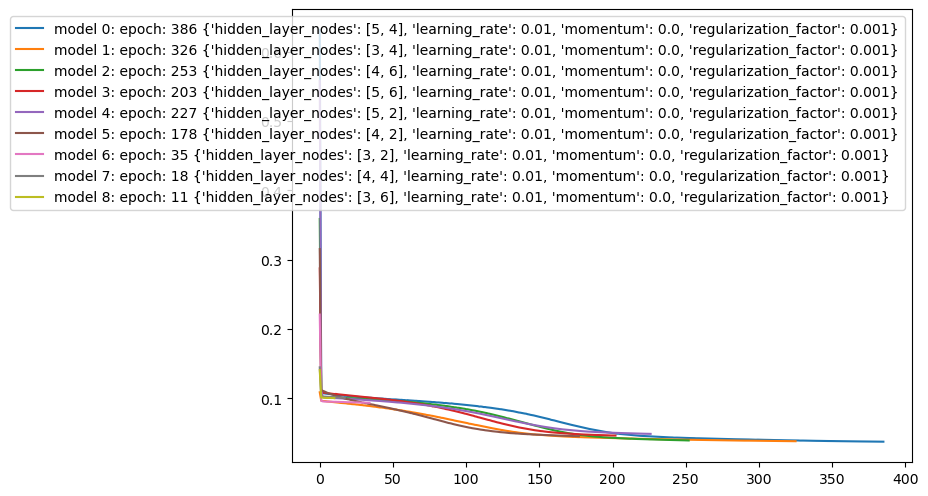

In [171]:
plt.figure(figsize=(8, 6), dpi=100)
for i, (param, model, history, final_val_mse, epoch) in enumerate(weight_eval_grid):
    plt.plot(history['loss'], label=f'model {i}: epoch: {epoch} {param}')
#plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()


# 3 Evaluate best and worst config

In [80]:
### Best
model_best = create_model()
es = EarlyStopping(monitor='val_mse', mode='min', patience=10, min_delta=0.0001, verbose=1, restore_best_weights=0)
history_best = model_best.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=10, callbacks=es)

perf_best = model_best.evaluate(X_test, y_test)
display(perf_best)
y_pred_best = model_best.predict(X_test)


New input layer: input_shape 5 nodes 5
New hidden layer: nodes 4
New output layer: output_shape 1
Epoch 1/500
80/80 [==============================] - 1s 4ms/step - loss: 0.0886 - mse: 0.0756 - val_loss: 0.0323 - val_mse: 0.0192
Epoch 2/500
80/80 [==============================] - 0s 2ms/step - loss: 0.0391 - mse: 0.0260 - val_loss: 0.0299 - val_mse: 0.0168
Epoch 3/500
80/80 [==============================] - 0s 2ms/step - loss: 0.0370 - mse: 0.0239 - val_loss: 0.0295 - val_mse: 0.0164
Epoch 4/500
80/80 [==============================] - 0s 3ms/step - loss: 0.0359 - mse: 0.0228 - val_loss: 0.0286 - val_mse: 0.0156
Epoch 5/500
80/80 [==============================] - 0s 4ms/step - loss: 0.0345 - mse: 0.0215 - val_loss: 0.0292 - val_mse: 0.0161
Epoch 6/500
80/80 [==============================] - 0s 3ms/step - loss: 0.0342 - mse: 0.0211 - val_loss: 0.0271 - val_mse: 0.0141
Epoch 7/500
80/80 [==============================] - 0s 3ms/step - loss: 0.0327 - mse: 0.0197 - val_loss: 0.0270 - v

[0.028671791777014732, 0.015696685761213303]

7/7 [==============================] - 0s 2ms/step


In [ ]:
### Worst
model_worst = create_model(hidden_layer_nodes=[4, 2],
                     regularizer=regularizers.L2(0.01),
                     momentum=0,
                     kernel_initializer=initializers.RandomNormal(mean=0., stddev=2.),
                     bias_initializer=initializers.RandomNormal(mean=0., stddev=2.),)
es = EarlyStopping(monitor='val_mse', mode='min', patience=10, min_delta=0.0001, verbose=1, restore_best_weights=0)
history_worst = model_worst.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=10, callbacks=es)

perf_worst = model_best.evaluate(X_test, y_test)
display(perf_worst)
y_pred_worst = model_worst.predict(X_test)


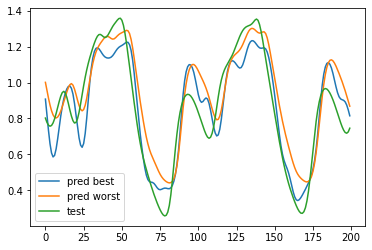

In [102]:
Xrange = range(len(y_pred_best))

plt.plot(Xrange, y_pred_best, label="pred best")
plt.plot(Xrange, y_pred_worst, label="pred worst")
plt.plot(Xrange, y_test, label="test")
plt.legend()
plt.show()

# With Noise

In [72]:
def add_gaussian_noise(data, mean=0.0, std=1.0):
    noise = np.random.normal(loc=mean, scale=std, size=data.shape)
    return data + noise


noise_sigma = [0.05, 0.15]

In [73]:
layers = [[5, 3], [5, 6], [5, 9]]
param_dict = dict(hidden_layer_nodes=layers,
                  regularizer=[regularizers.L2(0.1),
                               regularizers.L2(0.01),
                               regularizers.L2(0.001),
                               regularizers.L2(0.0001)]
                  )


In [76]:

X_train_noise_low = add_gaussian_noise(X_train, std=0.05)
y_train_noise_low = add_gaussian_noise(y_train, std=0.05)

X_val_noise_low = add_gaussian_noise(X_val, std=0.05)
y_val_noise_low = add_gaussian_noise(y_val, std=0.05)

noise_low_eval_grid = grid_search(param_dict, X_train_noise_low, y_train_noise_low, X_val_noise_low, y_val_noise_low)


12
{'hidden_layer_nodes': [5, 3], 'regularizer': <keras.regularizers.L2 object at 0x000001AAD67CDD00>}
New input layer: input_shape 5 nodes 5
New hidden layer: nodes 3
New output layer: output_shape 1
Epoch 1/500
80/80 [==============================] - 1s 5ms/step - loss: 7.2368 - mse: 0.1843 - val_loss: 0.1544 - val_mse: 0.0545
Epoch 2/500
80/80 [==============================] - 0s 3ms/step - loss: 0.1432 - mse: 0.0943 - val_loss: 0.1011 - val_mse: 0.0571
Epoch 3/500
80/80 [==============================] - 0s 3ms/step - loss: 0.1380 - mse: 0.0969 - val_loss: 0.1015 - val_mse: 0.0554
Epoch 4/500
80/80 [==============================] - 0s 3ms/step - loss: 0.1358 - mse: 0.0947 - val_loss: 0.1049 - val_mse: 0.0665
Epoch 5/500
80/80 [==============================] - 0s 3ms/step - loss: 0.1365 - mse: 0.0958 - val_loss: 0.1025 - val_mse: 0.0547
Epoch 6/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1353 - mse: 0.0940 - val_loss: 0.1036 - val_mse: 0.0641
Epoch 7/500
8

In [86]:

for i, (param, model, history, final_train_mse, final_val_mse, epoch) in enumerate(noise_low_eval_grid):
    config = param["regularizer"].get_config()
    print(i, final_train_mse, final_val_mse, epoch, config, param)


0 0.0103 0.0093 308 {'l2': 9.999999747378752e-05} {'hidden_layer_nodes': [5, 6], 'regularizer': <keras.regularizers.L2 object at 0x000001AAD679AC70>}
1 0.0094 0.0094 184 {'l2': 9.999999747378752e-05} {'hidden_layer_nodes': [5, 3], 'regularizer': <keras.regularizers.L2 object at 0x000001AAD679AC70>}
2 0.0227 0.0159 95 {'l2': 0.0010000000474974513} {'hidden_layer_nodes': [5, 6], 'regularizer': <keras.regularizers.L2 object at 0x000001AAD679A340>}
3 0.0197 0.0169 44 {'l2': 0.0010000000474974513} {'hidden_layer_nodes': [5, 9], 'regularizer': <keras.regularizers.L2 object at 0x000001AAD679A340>}
4 0.0099 0.0177 114 {'l2': 9.999999747378752e-05} {'hidden_layer_nodes': [5, 9], 'regularizer': <keras.regularizers.L2 object at 0x000001AAD679AC70>}
5 0.0161 0.0178 52 {'l2': 0.0010000000474974513} {'hidden_layer_nodes': [5, 3], 'regularizer': <keras.regularizers.L2 object at 0x000001AAD679A340>}
6 0.0961 0.0549 24 {'l2': 0.009999999776482582} {'hidden_layer_nodes': [5, 6], 'regularizer': <keras.re

In [75]:

X_train_noise_high = add_gaussian_noise(X_train, std=0.15)
y_train_noise_high = add_gaussian_noise(y_train, std=0.15)

X_val_noise_high = add_gaussian_noise(X_val, std=0.15)
y_val_noise_high = add_gaussian_noise(y_val, std=0.15)

noise_high_eval_grid = grid_search(param_dict, X_train_noise_high, y_train_noise_high, X_val_noise_high, y_val_noise_high)


12
{'hidden_layer_nodes': [5, 3], 'regularizer': <keras.regularizers.L2 object at 0x000001AAD67CDD00>}
New input layer: input_shape 5 nodes 5
New hidden layer: nodes 3
New output layer: output_shape 1
Epoch 1/500
80/80 [==============================] - 1s 4ms/step - loss: 7.0436 - mse: 0.1775 - val_loss: 0.1754 - val_mse: 0.0754
Epoch 2/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1690 - mse: 0.1202 - val_loss: 0.1221 - val_mse: 0.0754
Epoch 3/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1603 - mse: 0.1197 - val_loss: 0.1270 - val_mse: 0.0919
Epoch 4/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1628 - mse: 0.1223 - val_loss: 0.1203 - val_mse: 0.0781
Epoch 5/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1604 - mse: 0.1199 - val_loss: 0.1218 - val_mse: 0.0829
Epoch 6/500
80/80 [==============================] - 0s 2ms/step - loss: 0.1591 - mse: 0.1186 - val_loss: 0.1220 - val_mse: 0.0833
Epoch 7/500
8

In [87]:

for i, (param, model, history, final_train_mse, final_val_mse, epoch) in enumerate(noise_high_eval_grid):
    config = param["regularizer"].get_config()
    print(i, final_train_mse, final_val_mse, epoch, config, param)


0 0.0542 0.0505 54 {'l2': 0.0010000000474974513} {'hidden_layer_nodes': [5, 9], 'regularizer': <keras.regularizers.L2 object at 0x000001AAD679A340>}
1 0.0566 0.0508 50 {'l2': 0.0010000000474974513} {'hidden_layer_nodes': [5, 6], 'regularizer': <keras.regularizers.L2 object at 0x000001AAD679A340>}
2 0.0598 0.0525 121 {'l2': 9.999999747378752e-05} {'hidden_layer_nodes': [5, 3], 'regularizer': <keras.regularizers.L2 object at 0x000001AAD679AC70>}
3 0.0572 0.068 46 {'l2': 0.0010000000474974513} {'hidden_layer_nodes': [5, 3], 'regularizer': <keras.regularizers.L2 object at 0x000001AAD679A340>}
4 0.1234 0.0754 25 {'l2': 0.009999999776482582} {'hidden_layer_nodes': [5, 9], 'regularizer': <keras.regularizers.L2 object at 0x000001AB357F38B0>}
5 0.1174 0.0755 22 {'l2': 0.009999999776482582} {'hidden_layer_nodes': [5, 6], 'regularizer': <keras.regularizers.L2 object at 0x000001AB357F38B0>}
6 0.1207 0.0756 21 {'l2': 0.10000000149011612} {'hidden_layer_nodes': [5, 3], 'regularizer': <keras.regulari

7/7 [==============================] - 0s 4ms/step


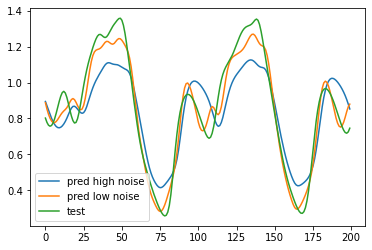

In [103]:
y_pred_low = noise_low_eval_grid[0][1].predict(X_test)
y_pred_high = noise_high_eval_grid[0][1].predict(X_test)
Xrange = range(len(y_pred_best))

plt.plot(Xrange, y_pred_high, label="pred high noise")
plt.plot(Xrange, y_pred_low, label="pred low noise")
plt.plot(Xrange, y_test, label="test")
plt.legend()
plt.show()